# Where should the gate be placed?


In Cookie Cats, as players progress through the game they will encounter gates that force them to wait some time or make an in-app purchase before they can progress. 

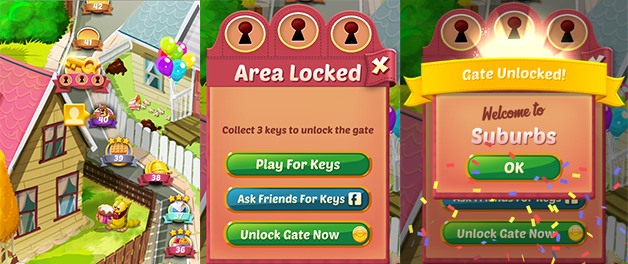

These gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

Analyze the result of an A/B test where the first gate was moved from level 30 to level 40. Look at the impact on player *retention* in particular.


# Dataset 
The data is from 90,189 players that installed the game while the AB-test was running. A player was randomly assigned to either gate_30 or gate_40 when installing the game.


*   userid - a unique number that identifies each player.
*   version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
*   sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
*   retention_1 - did the player come back and play 1 day after installing?
*   retention_7 - did the player come back and play 7 days after installing?



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Descriptive


In [3]:
# check if there is roughly the same number of players in each AB group
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

> **gameround distribution**



In [4]:
# number of players for each total gameround
df.groupby('sum_gamerounds')['userid'].count()

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64



* 3994 players never played the game, just installed it.



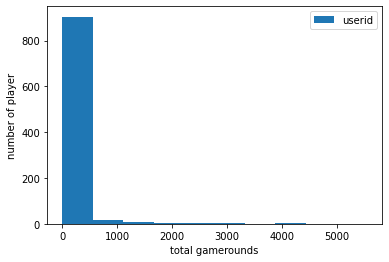

In [5]:
plot_df = df.groupby('sum_gamerounds')['userid'].agg('count').reset_index()
plot_df.plot(kind='hist', x='sum_gamerounds', y='userid')
plt.xlabel('total gamerounds')
plt.ylabel('number of player')
plt.show()

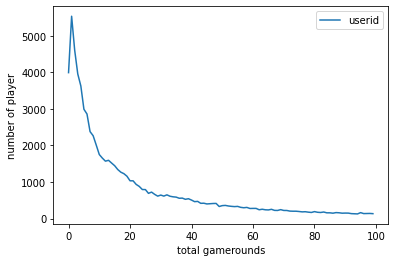

In [6]:
# players that played 0 to 100 gamerounds
plot_df[0:100].plot(x='sum_gamerounds', y='userid')
plt.xlabel('total gamerounds')
plt.ylabel('number of player')
plt.show()

> **overall 1-day retention & 7-day retention**

In [7]:
d1 = df['retention_1'].mean()
d7 = df['retention_7'].mean()

print(round((d1*100), 2), '% players come back 1 day after install')
print(round((d7*100), 2), '% players come back 7 day after install')

44.52 % players come back 1 day after install
18.61 % players come back 7 day after install


* benchmark:

  1-day retention - 44.52%

  7-day retention - 18.61%

> **retention by AB-group**

In [8]:
# 1-day for each group & 7-day for each group
prop_d1 = df.groupby('version')['retention_1'].mean()
prop_d7 = df.groupby('version')['retention_7'].mean()

print('The proportion of 1-day retention in each group is\n', prop_d1, '\n')
print('The proportion of 7-day retention in each group is\n', prop_d7)

The proportion of 1-day retention in each group is
 version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64 

The proportion of 7-day retention in each group is
 version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


In [9]:
d1_ab = (prop_d1[0]-prop_d1[1])/prop_d1[1]
d7_ab = (prop_d7[0]-prop_d7[1])/prop_d7[1]

print('1-day retention: gate_30 is' , round((d1_ab*100), 2), '% larger compared to gate_40')
print('7-day retention: gate_30 is' , round((d7_ab*100), 2), '% larger compared to gate_40')

1-day retention: gate_30 is 1.34 % larger compared to gate_40
7-day retention: gate_30 is 4.51 % larger compared to gate_40


* when gate was moved to level 40:

  decrease in 1-day retention (44.8% → 44.2%) ; 1.34 % difference between AB-groups

  decrease in 7-day retention (19.0% → 18.2%) ; 4.51 % difference between AB-groups

While we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here use bootstrapping.


# Bootstrapping
1. create 500 samples of dataset ; calculate 1-day & 7-day retentions for A/B groups
2. plot the bootstrap distributions
3. calculate retention difference between A/B groups
4. calculate the probability that 1-day & 7-day retentions are better when the gate is at level 30

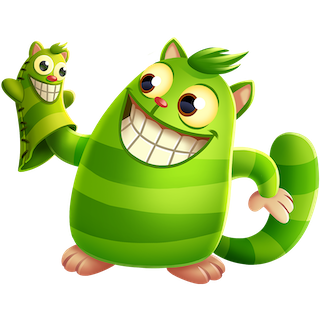




> **500 bootstrap replications & retention**



In [10]:
boot_1d = [(df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()) for i in range(500)]
boot_1d[:5]

[version
 gate_30    0.446971
 gate_40    0.443863
 Name: retention_1, dtype: float64, version
 gate_30    0.447455
 gate_40    0.441657
 Name: retention_1, dtype: float64, version
 gate_30    0.447950
 gate_40    0.443207
 Name: retention_1, dtype: float64, version
 gate_30    0.450377
 gate_40    0.446478
 Name: retention_1, dtype: float64, version
 gate_30    0.445310
 gate_40    0.444758
 Name: retention_1, dtype: float64]

In [11]:
boot_1d = pd.DataFrame(boot_1d)
boot_1d.head(3)

version,gate_30,gate_40
retention_1,0.446971,0.443863
retention_1,0.447455,0.441657
retention_1,0.447950,0.443207


In [12]:
boot_7d = [(df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()) for i in range(500)]
boot_7d = pd.DataFrame(boot_7d)
boot_7d.head(3)

version,gate_30,gate_40
retention_7,0.193071,0.177622
retention_7,0.190292,0.181195
retention_7,0.187829,0.182403




> **retention bootstrap distribution**


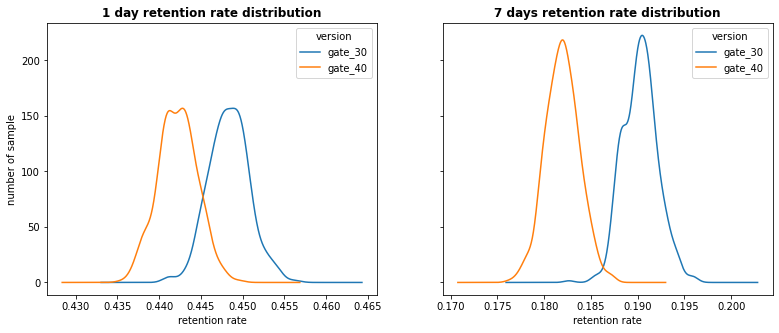

In [13]:
# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d[['gate_30', 'gate_40']].plot.kde(ax=ax1)
ax1.set_xlabel('retention rate')
ax1.set_ylabel('number of sample')
ax1.set_title('1 day retention rate distribution', fontweight='bold')

boot_7d[['gate_30', 'gate_40']].plot.kde(ax=ax2)
ax2.set_xlabel('retention rate')
ax2.set_title('7 days retention rate distribution', fontweight='bold')

plt.show()

distributions above represent the bootstrap uncertainty over what the underlying retention could be

> **zoom in on the retention difference between A/B groups**

add a col : A is diff % larger compared to B

diff > 0 : A > B (retention is greater when gate is at level 30)


In [14]:
# 1-day
boot_1d['diff'] = 100 * ((boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40'])
boot_1d['diff']

retention_1    0.700377
retention_1    1.312919
retention_1    1.070178
retention_1    0.873435
retention_1    0.124283
                 ...   
retention_1   -0.177058
retention_1    1.419786
retention_1    0.008418
retention_1    1.512524
retention_1    0.178845
Name: diff, Length: 500, dtype: float64

In [15]:
# probability of 'diff > 0'
prob_1d = (boot_1d['diff']>0).mean()
print(f'The probability that 1-day retention is greater when gate is at level 30: {prob_1d*100} %')

The probability that 1-day retention is greater when gate is at level 30: 96.2 %


Text(0.5, 0, '% difference')

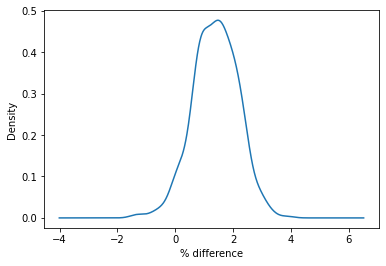

In [16]:
boot_1d['diff'].plot.kde()
plt.xlabel('% difference')

* for 1-day retention, the most likely difference is around 1% - 2%, and 96.2% of difference is above 0%

Since players have only been playing for one day, most of them might haven't reached level 30 yet and won't have been affected by the gate.

But after having played for a week, more players should have reached level 40.

In [17]:
# 7-day
boot_7d['diff'] = 100 * ((boot_7d['gate_30']-boot_7d['gate_40'])/boot_7d['gate_40'])
boot_7d['diff']

retention_7    8.697736
retention_7    5.020832
retention_7    2.974831
retention_7    3.279559
retention_7    2.823722
                 ...   
retention_7    2.743240
retention_7    4.464253
retention_7    3.483733
retention_7    4.553099
retention_7    6.223900
Name: diff, Length: 500, dtype: float64

In [18]:
prob_7d = (boot_7d['diff']>0).mean()
print(f'The probability that 7-day retention is greater when gate is at level 30: {prob_7d*100} %')

The probability that 7-day retention is greater when gate is at level 30: 100.0 %


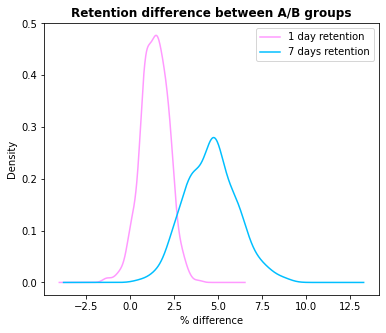

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

boot_1d['diff'].plot.kde(c='#ff99ff', label='1 day retention')
boot_7d['diff'].plot.kde(c='#00bfff', label='7 days retention')
ax.set_xlabel('% difference')
ax.set_title('Retention difference between A/B groups', fontweight='bold')
plt.legend()
plt.show()

* for 7-day retention, the most likely difference is around 4% - 6%, and 100% of difference is above 0% (in favor of a gate at level 30

This difference is larger than for 1-day retention, presumably because more players have had time to hit the first gate.

# Conclusion


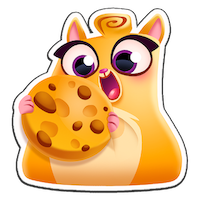

The bootstrap result shows that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

If we want to keep retention high — both 1-day and 7-day retention — we should **not** move the gate from level 30 to level 40. There are other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention *is* one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

Why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. Hedonic treadmill (hedonic adaptation) can give one explanation for this. In short, it is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.